---
title: 10.5 小批量随机梯度下降
date: 2024-8-7 13:00:00
tags: [机器学习,pytorch]
categories: [机器学习]
comment: true
toc: true
---
#  
<!--more-->
# 5 小批量随机梯度下降

## 5.1 向量化和缓存

- 尽量使用向量化操作，并行化计算

- 例如: 计算 $\mathbf{ A } = \mathbf{ B } \mathbf{ C }$我们有很多方法来计算A:
    - 1. 一次计算: $\mathbf{ A } _ { i j } = \mathbf{ B } _ { i , : } \cdot \mathbf{ C } _ { : , j }$ (一次将B的一行,C的一列放到cpu, 逐个计算)
    - 2. 一次计算: $\mathbf{ A } _ {:, j } = \mathbf{ B } \cdot \mathbf{ C } _ { : , j }$ (一次将整个B, C的一列放到cpu, 逐列计算)
    - 3. 一次计算: $\mathbf{ A } = \mathbf{ B } \cdot \mathbf{ C }$ (一次将整个B, C放到cpu, 一次计算)
    - 4. 将B, C分块, 逐块计算

In [10]:
%matplotlib inline
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l
timer = d2l.Timer()
A = torch.zeros(256, 256)
B = torch.randn(256, 256)
C = torch.randn(256, 256)

# 逐元素计算
timer.start()
for i in range(256):
    for j in range(256):
        A[i, j] = torch.dot(B[i, :], C[:, j])
print(f'逐元素计算: {timer.stop()} sec')

# 逐列计算
timer.start()
for j in range(256):
    A[:, j] = torch.mv(B, C[:, j])
print(f'逐列计算: {timer.stop()} sec')

# 一次性计算
timer.start()
A = torch.mm(B, C)
print(f'一次性计算: {timer.stop()} sec')

#gigaflops是一种计算机性能的单位，表示每秒十亿次浮点运算
gigaflops = [2/i for i in timer.times]
print(f'逐元素计算: {gigaflops[0]} Gflops')
print(f'逐列计算: {gigaflops[1]} Gflops')
print(f'一次性计算: {gigaflops[2]} Gflops')

逐元素计算: 0.9588320255279541 sec
逐列计算: 0.003960132598876953 sec
一次性计算: 0.000997781753540039 sec
逐元素计算: 2.0858710876900006 Gflops
逐列计算: 505.0335942203492 Gflops
一次性计算: 2004.4463560334527 Gflops


## 5.2 小批量

- 处理单个观测值需要我们执行许多单一矩阵‐矢量（甚至矢量‐矢量）乘法，这耗费相当大，而且对应深度学习框架也要巨大的开销。这既适用于计算梯度以更新参数时，也适用于用神经网络预测。也就是说，每当我们执行$\mathbf{ W } \leftarrow \mathbf{ W } - \eta _ t g _ t$时, 消耗巨大. 其中
$$ \mathbf{ g } _ t = \partial _ w f ( \mathbf{ x } _ t , \mathbf{ w } ) $$

- 通过将其应用于一个小批量观测值来提高此操作的计算效率:
$$ \mathbf{ g } _ t = \partial _ w \frac{ 1 }{ | \mathcal{ B } _ t | } \sum _ { i \in \mathcal{ B } _ t } f ( \mathbf{ x } _ i , \mathbf{ w } ) $$

- 由于$\mathbf{ x }_ t$和小批量$\mathbf{B}_ t$的所有元素都是从训练集中随机抽出的，因此梯度的期望保持不变。另一方面，方差显著降低。由于小批量梯度由正在被平均计算的b:=|Bt|个独立梯度组成，其标准差降低了$b ^ {− \frac{1}{2}}$。这本身就是一件好事，因为这意味着更新与完整的梯度更接近了。

- 执行相同的矩阵乘法, 这次将其一次性分为64列的小批量:

In [13]:
timer.start()
for j in range(0, 256, 64):
    A[:, j:j+64] = torch.mm(B, C[:, j:j+64])
print(f'分块计算: {timer.stop()} sec')
print(f'分块计算: {2 / timer.times[3]} Gflops')

分块计算: 0.001994609832763672 sec
分块计算: 552.8641666117445 Gflops


## 5.3 读取数据集

- 如何从数据中有效地生成小批量。使用NASA开发的测试机翼的数据集'不同飞行器产生的噪声'来比较这些优化算法。为方便起见，我们只使用前1,500样本。数据已作预处理：我们移除了均值并将方差重新缩放到每个坐标为1。

In [19]:
#@save
d2l.DATA_HUB['airfoil'] = (d2l.DATA_URL + 'airfoil_self_noise.dat', '76e5be1548fd8222e5074cf0faae75edff8cf93f')
#@save
def get_data_ch11(batch_size = 10, n = 1500):
    data = np.genfromtxt(d2l.download('airfoil',cache_dir='C:\\Users\\admin\\.cache'), dtype=np.float32, delimiter='\t')
    data = torch.from_numpy((data - data.mean(axis=0)) / data.std(axis=0)) # 标准化
    print(data.shape)
    data_iter = d2l.load_array((data[:n, :-1], data[:n, -1]), batch_size, is_train=True) # 只取前n个样本, label在最后一列
    print(data_iter)
    return data_iter, data.shape[1]-1
# get_data_ch11()

## 5.4 从零开始实现

loss: 0.248, 0.023 sec/epoch


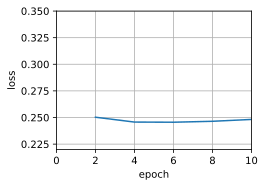

In [21]:
def sgd(params ,states, hyperparams):
    for p in params:
        p.data.sub_(hyperparams['lr'] * p.grad) # 更新参数 p = p - lr * p.grad
        p.grad.data.zero_()

#一个通用的训练函数, 初始化了一个线性回归模型, 使用不同的优化算法来训练模型
#@save
def train_ch11(trainer_fn, states, hyperparams, data_iter, feature_dim, num_epochs=2):
    #初始化模型
    w = torch.normal(mean=0.0, std=0.01, size=(feature_dim, 1), requires_grad=True)
    b = torch.zeros((1), requires_grad=True)
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    # 训练模型
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, d2l.Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            l = loss(net(X), y).mean()
            l.backward()
            trainer_fn([w,b], states, hyperparams) # 优化算法
            n += X.shape[0] #shape[0]是batch_size, 用于计算总样本数
            if n%200 == 0: # 每200个样本记录一次loss
                timer.stop()
                animator.add( n/X.shape[0] / len(data_iter), (d2l.evaluate_loss(net, data_iter, loss),)) # 计算loss
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')
    return timer.cumsum(), animator.Y[0]

# 优化算法: 批量梯度下降(minibatch = 样本总数n)
def train_sgd(lr, batch_size, num_epochs=2):
    data_iter, feature_dim = get_data_ch11(batch_size)
    return train_ch11(sgd, None, {'lr': lr}, data_iter, feature_dim, num_epochs)
gd_res = train_sgd(1, 1500, 10)

- 上面的batch=n, 计算loss使用了全部数据, 属于梯度下降法, 每个epoch只更新一次参数
- 这里batch=1, 计算loss使用了一个数据, 属于随机梯度下降法, 每个epoch更新n次参数

loss: 0.248, 0.054 sec/epoch


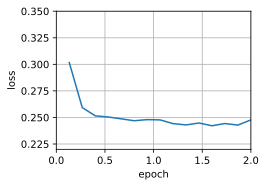

In [22]:
sgd_res = train_sgd(0.005, 1)

- 尽管两个例子在一个迭代轮数内都处理了1500个样本，但实验中随机梯度下降的一个迭代轮数耗时更多。这是因为随机梯度下降更频繁地更新了参数，而且一次处理单个观测值效率较低。

- 设置batch_size = 100, 随机梯度下降速度甚至优于梯度下降法

loss: 0.245, 0.003 sec/epoch


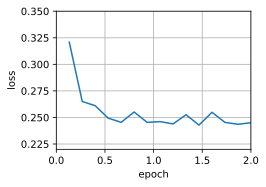

In [23]:
mini1_res = train_sgd(.4, 100)

- 尽管在处理的样本数方面，随机梯度下降的收敛速度快于梯度下降，但与梯度下降相比，它需要更多的时间来达到同样的损失，因为逐个样本来计算梯度并不那么有效。
- 小批量随机梯度下降能够平衡收敛速度和计算效率。大小为10的小批量比随机梯度下降更有效；大小为100的小批量在运行时间上甚至优于梯度下降。

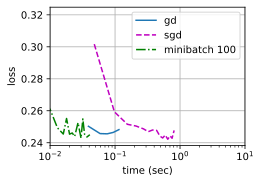

In [26]:
d2l.set_figsize([6, 3])
d2l.plot(*list(map(list, zip(gd_res, sgd_res, mini1_res))), # *list(map(list, zip()))将元组转换为列表
         'time (sec)', 'loss', xlim=[1e-2, 10],
         legend=['gd', 'sgd', 'minibatch 100'])
d2l.plt.gca().set_xscale('log')

## 5.5 简洁实现


loss: 0.243, 0.008 sec/epoch


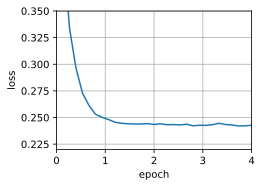

In [27]:
#@save
def train_concise_ch11(trainer_fn, hyperparams, data_iter, num_epochs=4):
    # 初始化模型
    net  = nn.Sequential(nn.Linear(5, 1))
    def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.normal_(m.weight, std=0.01)
    net.apply(init_weights)

    optimizer = trainer_fn(net.parameters(), **hyperparams)
    loss = nn.MSELoss(reduction='none')
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, d2l.Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            optimizer.zero_grad()
            out = net(X)
            y = y.reshape(out.shape)
            l = loss(out, y)
            l.mean().backward()
            optimizer.step()
            n += X.shape[0]
            if n%200 == 0:
                timer.stop()
                # mseloss计算平方误差时不带系数1/2
                animator.add(n/X.shape[0]/len(data_iter), (d2l.evaluate_loss(net, data_iter, loss)/2,))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')
data_iter, _ = get_data_ch11(10)
trainer = torch.optim.SGD
train_concise_ch11(trainer, {'lr': 0.01}, data_iter)